In [1]:
#STIX simulator

In [2]:
import sys
sys.path.append('.')
import glob
import numpy as np
import math
from core.grid_parameters import NOMINAL as ngd


import matplotlib.pyplot as plt


from ipywidgets import interact, interact_manual, widgets


from IPython.display import clear_output

from core.stix_imager import StixImager
from core import stix_grid as sgd


%matplotlib notebook

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
def gaus2d( sun_x=0, sun_y=0, x_radius=30, y_radius=30, sigma=10, rho=0, steps=40, xmin=None, 
           xmax=None,  ymin=None, ymax=None):
    if xmin is None or ymin is None or xmax is None or ymax is None:
        xmin=sun_x-x_radius
        xmax=sun_x+x_radius
        ymin=sun_y-y_radius
        ymax=sun_y+y_radius
    xx,yy=np.meshgrid(np.linspace(xmin,xmax,steps), np.linspace(ymin,ymax,steps))
    u=(xx-sun_x)/sigma
    v=(yy-sun_y)/sigma
    c=1.-rho*rho
    z=u*u-2*rho*u*v+v*v
            # Calculating Gaussian array
    zz = np.exp(-( z/  2.0 * c ) )
    return xx,yy,zz
#x,y,z=gaus2d()

#plt.pcolormesh(x, y, z)

In [5]:
import pickle
def create_pattern_lut(det_idx):
    pkf = open(f'./data/pattern_lut_{det_idx}.pkl', 'wb')
    res=math.asin(ngd[str(det_idx+1)]['FrontPitch']/597.)*180/math.pi
    steps=2*int(1./res)
    im=StixImager(det_idx)
    xx=np.linspace(-1,1,steps)
    yy=np.linspace(-1,1,steps)    
    results={'res':res*3600,'steps':steps, 'x':xx,'y':yy, 'pattern':{}}
    print(steps)
    for i in range(steps):
        for j in range(steps):
            clear_output(wait=True)
            x=xx[i]*3600
            y=yy[j]*3600
            print(f'completed: {100*(i*steps+j)/(steps*steps):.1f}%')
          
            res=im.create(x, y, 0,0,0,0, compute_pattern=True)
            results['pattern'][(i,j)]=res
            
    pickle.dump(results, pkf)
    pkf.close()

#create_pattern_lut(25)


# Gaussian  shape source simulator

In [6]:


def get_vis_amp(c, ce):
    real,img=c[2]-c[0], c[3]-c[1]
    mean=np.mean(c)
    real_error=np.sqrt(ce[2]**2+ce[0]**2)
    img_error=np.sqrt(ce[1]**2+ce[3]**2)
    f=lambda x,y,xe,ye, mean:  [np.sqrt(x**2+y**2)/mean, (1./mean) *np.sqrt((xe*x)**2+(ye*y)**2)/np.sqrt(x**2+y**2)]
    return f(real, img, real_error, img_error, mean)

#import core.fit_pattern as fp
#def get_amplitudes(pattern):
#    res=fp.fit(pattern)
#    return res['amp'] 

def read_data(filename):
    exp=[]
    exp_error=[]
    with open(filename) as f:
        lines=[l.split() for l in f.readlines()]
        #print(lines)
        sun_x, sun_y=float(lines[0][0]),float(lines[0][1]) 
        exp=[float(l[2]) for l in lines[1:]]
        exp_error=[float(l[3]) for l in lines[1:]]

    vis={}

    for i in range(32):
        top=get_vis_amp(exp[i*12:i*12+4],  exp_error[i*12:i*12+4] )
        bottom=get_vis_amp(exp[i*12+4:i*12+8], exp_error[i*12+4:i*12+8] )

        vis[i]={'top':top, 'bottom':bottom}
        
    return sun_x,sun_y, vis




results=[]
detectors=np.array([10,17,12,16,18,11,6,28,0,4,22,24,1,5,29,30,14,26,7,23,27,20,25,3,15,13,31,2,21,19])
#index
sun_x,sun_y,exp_vis =read_data('exp_data/flare_20210507.txt')


exp_amps_top=[exp_vis[i]['top'][0]  for i in detectors]  #measured amplitude 

exp_amps_top_error=[exp_vis[i]['top'][1]  for i in detectors]  #measured amplitude 
exp_amps_bottom=[exp_vis[i]['bottom'][0]  for i in detectors] #measured amplitude
exp_amps_bottom_error=[exp_vis[i]['bottom'][1]  for i in detectors]  #measured amplitude 

plt.figure()
x=range(len(detectors))
plt.errorbar(x, exp_amps_top, yerr=exp_amps_top_error, label="top")
plt.errorbar(x, exp_amps_bottom, yerr=exp_amps_bottom_error, label="bottom")
ax=plt.gca()
ax.set_xticklabels(detectors+1)
ax.set_title('amplitude')
ax.set_xlabel('Detector #')
ax.set_ylabel('Amplitude / mean')








<IPython.core.display.Javascript object>

Text(0, 0.5, 'Amplitude / mean')

In [10]:
#https://pub023.cs.technik.fhnw.ch/view/list/bsd/id/2178
import pickle

print('creating imager instances')
imagers={i:StixImager(i) for i in detectors}
result_sim={}
steps=20



fsav=open('amp_imag.pickle','wb')

def find_solution(sigma):

    #for sigma in np.linspace(7,30,4):
    if True:
        x_radius=2*sigma
        y_radius=2*sigma
        rho=0
        #steps=20
        xx,yy,zz=gaus2d(sun_x, sun_y, x_radius, y_radius, sigma, rho, steps)
        x1d=xx.reshape(-1)
        y1d=yy.reshape(-1)
        z1d=zz.reshape(-1)
    
        ns=x1d.size
    
        sum_cor=0
        det_res={}
        for det_idx in reversed(detectors):     
            #det_idx=19
            print(det_idx)
            idx=list(detectors).index(det_idx)
            exp_amps=(exp_amps_top[idx],
                      exp_amps_bottom[idx])
            pattern=np.zeros(12)  
            for i in range(ns):
                #clear_output(wait=True)
                #print(f'completed: {100.*i/ns:.1f}%')
                x=x1d[i]
                y=y1d[i]
                if z1d[i]>0:
                    #print(x,y)
                    res=imagers[det_idx].create(x, y, 0,0,0,0, compute_pattern=True)
                    pattern+=res['pattern']*z1d[i]
            pattern=pattern/np.sum(z1d)
        
        
        
            tp= get_vis_amp(pattern[0:4], np.zeros(4))
            btm = get_vis_amp(pattern[4:8],np.zeros(4))
            det_res[det_idx]={
                'top':tp[0],
                'bottom':btm[0],
                'det_idx':det_idx,
                'pattern':pattern
            }

            sum_cor+=tp[0]*exp_amps[0]
        
        
        
        this_res={
                'sun_x':sun_x,
                'sun_y':sun_y,
                'det_result':det_res,
       
                'sigma':sigma,
                'cof':sum_cor
            }
        result_sim[sigma]=this_res
    #print(result_sim)
    

from multiprocessing import Pool    
pool = Pool(8) 
#pool.map(find_solution, np.linspace(7,30,4))    
    

dat={
        'result_sim':result_sim,
        'detectors':detectors
        }

pickle.dump(dat, fsav)
f=plt.figure()
plt.plot()
print('done')
print(sun_x,sun_y, result)
    


creating imager instances
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter

In [24]:
fsav=open('amp_imag2.pickle','wb')
print('creating imager instances')
imagers={i:StixImager(i) for i in detectors}

steps=20
results={}

def sim_amplitude(det_idx):
    global results
    x_radius=2*sigma
    y_radius=2*sigma
    rho=0
    #steps=20
    xx,yy,zz=gaus2d(sun_x, sun_y, x_radius, y_radius, sigma, rho, steps)
    x1d=xx.reshape(-1)
    y1d=yy.reshape(-1)
    z1d=zz.reshape(-1)
    ns=x1d.size

    sum_cor=0
    det_res={}
    #det_idx=19
    print('detector',  det_idx)
    idx=list(detectors).index(det_idx)
    exp_amps=(exp_amps_top[idx],
          exp_amps_bottom[idx])
    pattern=np.zeros(12)  
    for i in range(ns):
        x=x1d[i]
        y=y1d[i]
        if z1d[i]>0:
            res=imagers[det_idx].create(x, y, 0,0,0,0, compute_pattern=True)
            pattern+=res['pattern']*z1d[i]
    pattern=pattern/np.sum(z1d)
    tp= get_vis_amp(pattern[0:4], np.zeros(4))
    btm = get_vis_amp(pattern[4:8],np.zeros(4))
    res={
    'top':tp[0],
    'bottom':btm[0],
    'det_idx':det_idx,
    'pattern':pattern
    }
    results[det_idx]=res
    print(res)
    return res

from multiprocessing import Pool    
pool = Pool(8) 
pool.map(sim_amplitude, detectors)  
pickle.dump(results, fsav)
fsav.close()



creating imager instances
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
30
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parameter: nominal
Grid parame

       0.24370247, 0.40235092])}
detector 19
{'top': 1.3842154522348586, 'bottom': 1.3961549430965574, 'det_idx': 2, 'pattern': array([3.42596849, 3.82929665, 1.47490388, 1.05969757, 3.42865367,
       3.81744876, 1.45606996, 1.04537845, 0.25064237, 0.43049668,
       0.22522132, 0.06584907])}
{'top': 1.4791065944449746, 'bottom': 1.437176942548424, 'det_idx': 21, 'pattern': array([2.62180894, 4.20650269, 2.26576421, 0.62886079, 2.57821466,
       4.21222443, 2.31418095, 0.69955136, 0.1832172 , 0.42023904,
       0.29517323, 0.06097754])}
{'top': 1.4158351615080373, 'bottom': 1.3935317356262762, 'det_idx': 19, 'pattern': array([0.97548039, 3.35112614, 4.00465564, 1.58090873, 1.00602518,
       3.5505501 , 4.21245173, 1.76522457, 0.03978182, 0.20626262,
       0.37093316, 0.18431516])}
{'top': 1.4275437583339954, 'bottom': 1.4320764513602937, 'det_idx': 31, 'pattern': array([3.04166638, 0.80202176, 1.8793336 , 4.11515563, 3.03938203,
       0.79270448, 1.89462583, 4.13122117, 0.34514442

In [34]:
fsav=open('amp_imag.pickle','wb')
import array 
result=[{'top': 1.2234996465466568, 'bottom': 1.2265376303927915, 'det_idx': 30, 'pattern': [1.62107806, 1.29457375, 3.47802532, 3.7988552 , 1.61537867,
       1.29430692, 3.47327956, 3.80624881, 0.20759518, 0.07635352,
       0.27434795, 0.40270433]},
{'top': 1.2293098736157888, 'bottom': 1.2294425224461492, 'det_idx': 26, 'pattern': [3.57231103, 3.73101611, 1.51457625, 1.37080761, 3.56606863,
       3.73409143, 1.51410777, 1.37015792, 0.29218637, 0.38025158,
       0.20656276, 0.08350954]},
{'top': 1.333425571995004, 'bottom': 1.3366731161649374, 'det_idx': 23, 'pattern': [4.07725658, 3.0616189 , 0.93131985, 1.9443967 , 4.08708095,
       3.07341494, 0.92977412, 1.94414489, 0.35058568, 0.3461071 ,
       0.11882458, 0.12345241]},
{'top': 1.3590033832307715, 'bottom': 1.3576758748737012, 'det_idx': 25, 'pattern': [1.61680852, 1.02930148, 3.33910443, 3.9208115 , 1.61077007,
       1.05071761, 3.37021938, 3.94339019, 0.20858381, 0.04542427,
       0.24370247, 0.40235092]},
{'top': 0.09993873716837628, 'bottom': 0.09967574849354488, 'det_idx': 16, 'pattern': [3.13927066, 2.97097017, 2.84274619, 3.00813946, 3.13893327,
       2.97152731, 2.84307812, 3.00773189, 0.29384333, 0.28372314,
       0.2649383 , 0.27466938]},
{'top': 0.45298851041896804, 'bottom': 0.45279855026034477, 'det_idx': 6, 'pattern': [2.7826914 , 2.17591708, 2.83974163, 3.4482882 , 2.78380486,
       2.17580886, 2.83898738, 3.4476882 , 0.28751518, 0.20243443,
       0.23890402, 0.32190729]},
{'top': 0.45231622726118215, 'bottom': 0.45228104182920487, 'det_idx': 0, 'pattern': [2.18025191, 2.88997137, 3.44261627, 2.73477044, 2.18039189,
       2.8904033 , 3.44258031, 2.73441602, 0.20126164, 0.24340632,
       0.32415674, 0.28226064]},
{'top': 0.0009912052474411682, 'bottom': 0.0030769922621887856, 'det_idx': 12, 'pattern': [3.23775282, 3.23765995, 3.24018501, 3.23975538, 3.23640391,
       3.24010491, 3.24483262, 3.24543885, 0.30674624, 0.30605846,
       0.30356094, 0.30076777]},
{'top': 0.803728105387126, 'bottom': 0.8049404540607358, 'det_idx': 24, 'pattern': [1.94011364, 1.88177613, 3.40752988, 3.44646885, 1.94247212,
       1.90204834, 3.43694656, 3.46518717, 0.20402138, 0.14569298,
       0.2948111 , 0.36767361]},
{'top': 0.8155003127036686, 'bottom': 0.8155917592496634, 'det_idx': 4, 'pattern': [1.63131061, 2.38983934, 3.74035231, 2.97797962, 1.63128882,
       2.38955561, 3.74043895, 2.97829131, 0.16621888, 0.17914045,
       0.33561507, 0.32256811]},
{'top': 1.0818344011499634, 'bottom': 1.0817833349899233, 'det_idx': 1, 'pattern': [1.20799107, 2.42335085, 4.00139794, 2.77907923, 1.20822062,
       2.42174971, 4.00097248, 2.7802788 , 0.12333566, 0.16895446,
       0.36349005, 0.31742022]},
{'top': 0.47137110694943196, 'bottom': 0.4715183130815952, 'det_idx': 28, 'pattern': [3.3424982 , 2.4147748 , 2.2806462 , 3.20764874, 3.34248062,
       2.4150047 , 2.28018477, 3.20799506, 0.32846565, 0.24875345,
       0.19676248, 0.27683965]},
{'top': 0.8153848903794834, 'bottom': 0.8156059877940616, 'det_idx': 22, 'pattern': [2.75156501, 3.77843527, 2.61595473, 1.59345198, 2.75175479,
       3.77877997, 2.61580412, 1.59319679, 0.21075006, 0.35450679,
       0.29080245, 0.14747631]},
{'top': 1.0777953060124459, 'bottom': 1.0781203409154794, 'det_idx': 5, 'pattern': [3.90751912, 2.0808759 , 1.30274363, 3.12853129, 3.90546426,
       2.07806356, 1.30199722, 3.12368495, 0.38594483, 0.24903383,
       0.10014828, 0.23679338]},
{'top': 1.0863372541272702, 'bottom': 1.0882136706861663, 'det_idx': 29, 'pattern': [1.19567602, 2.45197985, 4.00676911, 2.75708066, 1.19826823,
       2.45471371, 4.01619443, 2.74280111, 0.12011452, 0.17046889,
       0.36704118, 0.31465264]},
{'top': 1.2293098736157888, 'bottom': 1.2294425224461492, 'det_idx': 26, 'pattern': [3.57231103, 3.73101611, 1.51457625, 1.37080761, 3.56606863,
       3.73409143, 1.51410777, 1.37015792, 0.29218637, 0.38025158,
       0.20656276, 0.08350954]},
{'top': 1.2234996465466568, 'bottom': 1.2265376303927915, 'det_idx': 30, 'pattern': [1.62107806, 1.29457375, 3.47802532, 3.7988552 , 1.61537867,
       1.29430692, 3.47327956, 3.80624881, 0.20759518, 0.07635352,
       0.27434795, 0.40270433]},
{'top': 1.2433383111337837, 'bottom': 1.2444718339377874, 'det_idx': 14, 'pattern': [3.13550542, 1.07989513, 1.95432399, 4.018082  , 3.14151028,
       1.07729944, 1.96009262, 4.0233434 , 0.35252433, 0.13438764,
       0.12344822, 0.34144617]},
{'top': 1.3004415070521433, 'bottom': 1.304471145466646, 'det_idx': 7, 'pattern': [3.6820668 , 1.37905462, 1.32669744, 3.62700075, 3.69549361,
       1.38125389, 1.32339737, 3.63666584, 0.40155515, 0.19077876,
       0.06613833, 0.27970465]},
{'top': 1.3121715778809009, 'bottom': 1.3148146874229363, 'det_idx': 27, 'pattern': [3.4902576 , 3.8249732 , 1.52687181, 1.18563432, 3.51550325,
       3.85406048, 1.53763957, 1.18913232, 0.30195984, 0.45128395,
       0.22918097, 0.05106905]},
{'top': 1.4196324604655077, 'bottom': 1.4011957544635376, 'det_idx': 20, 'pattern': [2.60015089, 4.25757434, 2.31622555, 0.74774814, 2.67025262,
       4.19353664, 2.3162646 , 0.73750709, 0.16641237, 0.43307447,
       0.28033265, 0.05345289]},
{'top': 1.4547748019300442, 'bottom': 1.4646289566067876, 'det_idx': 15, 'pattern': [4.20447587, 2.65801686, 0.69503878, 2.18072951, 4.24647198,
       2.66417221, 0.69536445, 2.18148613, 0.27938446, 0.34245293,
       0.11725847, 0.18378986]},
{'top': 1.3514515645172749, 'bottom': 1.3655505969765664, 'det_idx': 3, 'pattern': [3.84324445, 1.54167985, 1.08812573, 3.45499191, 3.87552633,
       1.52460299, 1.08352288, 3.44868205, 0.4136157 , 0.20831048,
       0.05457692, 0.25009019]},
{'top': 1.333425571995004, 'bottom': 1.3366731161649374, 'det_idx': 23, 'pattern': [4.07725658, 3.0616189 , 0.93131985, 1.9443967 , 4.08708095,
       3.07341494, 0.92977412, 1.94414489, 0.35058568, 0.3461071 ,
       0.11882458, 0.12345241]},
{'top': 1.3664935352960679, 'bottom': 1.3768207966242991, 'det_idx': 13, 'pattern': [3.41284362, 3.73710674, 1.42507771, 1.09749076, 3.52814925,
       3.87074265, 1.4632326 , 1.12318706, 0.30128267, 0.43393655,
       0.18727972, 0.0547661 ]},
{'top': 1.3590033832307715, 'bottom': 1.3576758748737012, 'det_idx': 25, 'pattern': [1.61680852, 1.02930148, 3.33910443, 3.9208115 , 1.61077007,
       1.05071761, 3.37021938, 3.94339019, 0.20858381, 0.04542427,
       0.24370247, 0.40235092]},
{'top': 1.3842154522348586, 'bottom': 1.3961549430965574, 'det_idx': 2, 'pattern': [3.42596849, 3.82929665, 1.47490388, 1.05969757, 3.42865367,
       3.81744876, 1.45606996, 1.04537845, 0.25064237, 0.43049668,
       0.22522132, 0.06584907]},
{'top': 1.4791065944449746, 'bottom': 1.437176942548424, 'det_idx': 21, 'pattern': [2.62180894, 4.20650269, 2.26576421, 0.62886079, 2.57821466,
       4.21222443, 2.31418095, 0.69955136, 0.1832172 , 0.42023904,
       0.29517323, 0.06097754]},
{'top': 1.4158351615080373, 'bottom': 1.3935317356262762, 'det_idx': 19, 'pattern': [0.97548039, 3.35112614, 4.00465564, 1.58090873, 1.00602518,
       3.5505501 , 4.21245173, 1.76522457, 0.03978182, 0.20626262,
       0.37093316, 0.18431516]},
{'top': 1.4275437583339954, 'bottom': 1.4320764513602937, 'det_idx': 31, 'pattern': [3.04166638, 0.80202176, 1.8793336 , 4.11515563, 3.03938203,
       0.79270448, 1.89462583, 4.13122117, 0.34514442, 0.11923718,
       0.11477966, 0.34068897]},
{'top': 0.1145623352841484, 'bottom': 0.11457261214499981, 'det_idx': 18, 'pattern': [3.06015344, 2.83451464, 2.92102092, 3.14763106, 3.06054315,
       2.8344599 , 2.91968612, 3.1467799 , 0.29235058, 0.26785015,
       0.26623274, 0.29068583]},
{'top': 0.13956042606364233, 'bottom': 0.13956015350846968, 'det_idx': 11, 'pattern': [3.08095273, 3.17892528, 2.89985023, 2.80288625, 3.07998311,
       3.17939124, 2.90083373, 2.80241825, 0.27953791, 0.30037633,
       0.27894251, 0.25822413]},
{'top': 0.0008536391364317358, 'bottom': 0.0008555958539517718, 'det_idx': 10, 'pattern': [3.24123528, 3.23941617, 3.24014417, 3.24195828, 3.24120517,
       3.23939243, 3.24012797, 3.24194733, 0.30281009, 0.30261051,
       0.30260645, 0.30280818]},
{'top': 0.0008506117803752544, 'bottom': 0.0008464397297402869, 'det_idx': 17, 'pattern': [3.24202865, 3.24099233, 3.23934589, 3.24035875, 3.24208518,
       3.24105633, 3.23941439, 3.24043065, 0.30274718, 0.30272673,
       0.30253102, 0.30255315]}]

data={'detectors':detectors, 'result':result}
pickle.dump(data, fsav)
results={x['det_idx']: x for x in result}
#print(dat)

{}


<IPython.core.display.Javascript object>


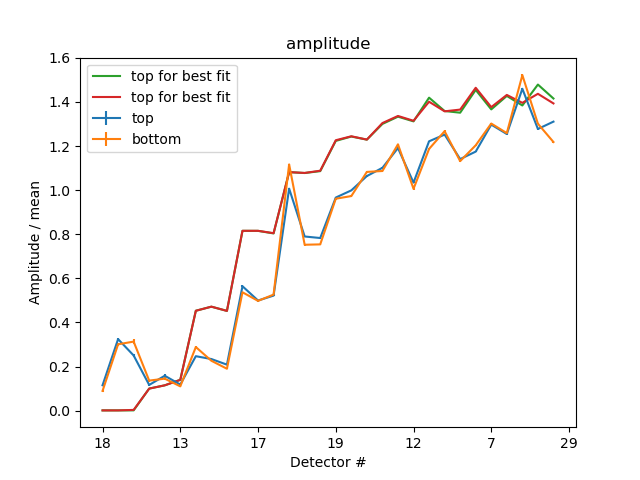

Text(0, 0.5, 'Amplitude / mean')

In [36]:
best_sigma=7
print(result_sim)

#fsav.close()
best_amp_top =[ results[i]['top']   for i in detectors]
best_amp_bottom =[ results[i]['bottom']   for i in detectors]


plt.figure()
x=range(len(detectors))
plt.errorbar(x, exp_amps_top, yerr=exp_amps_top_error, label="top")
plt.errorbar(x, exp_amps_bottom, yerr=exp_amps_bottom_error, label="bottom")
plt.plot(x,  best_amp_top, label='top for best fit' )
plt.plot(x,  best_amp_bottom, label='top for best fit' )
ax=plt.gca()
ax.set_xticklabels(detectors+1)
ax.set_title('amplitude')
ax.set_xlabel('Detector #')
plt.legend()
ax.set_ylabel('Amplitude / mean')


In [ ]:




def simulate_gaus(det_idx, sun_x, sun_y, x_radius=30, y_radius=30,sigma=10,rho=0, steps=40
            ):
 
    
    im=StixImager(det_idx)
    
    
    xx,yy,zz=gaus2d(sun_x, sun_y, x_radius, y_radius, sigma, rho, steps)
    x1d=xx.reshape(-1)
    y1d=yy.reshape(-1)
    z1d=zz.reshape(-1)
    pattern=np.zeros(12)
    
    ns=x1d.size
    for i in range(ns):
        clear_output(wait=True)
        print(f'completed: {100.*i/ns:.1f}%')
        x=x1d[i]
        y=y1d[i]
        if z1d[i]>0:
            #print(x,y)
            res=im.create(x, y, 0,0,0,0, compute_pattern=True)
            pattern+=res['pattern']*z1d[i]
    pattern=pattern/np.sum(z1d)
    result=get_amplitudes(pattern)
    res=im.create(sun_x, sun_y, 0,0,0,0, compute_pattern=True)
    fig, ((ax, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(8, 8))
    ax.pcolormesh(xx, yy, zz)
    im.plot(fig, ax2, ax3)


    
    #print(pattern)
    ax3.plot(range(8),pattern[0:8], label='gaussian source')
    ax3.set_title(f'sun_x={sun_x} sun_y={sun_y} x_r={x_radius}, y_r={y_radius}, sigma={sigma} ')
    ax3.set_xlabel('Pixel')
    ax3.set_xlim(0,8)
    ax3.set_ylabel('Open area (mm)')
    ax3.legend()
    
    #result=fit_pattern(pattern)
    
    print('Pattern, result', result)
    #print(result)
    x1=np.arange(4)
    ax4.plot(x1,pattern[0:4], label='top')
    ax4.plot(x1,pattern[4:8], label='bottom')
    #x2=np.linspace(0,8,50)
    #pt=result['params'][0]
    #pb=result['params'][1]
    #print(pt)
    #y_top, y_bottom=fun_sin(x2, pt[0], pt[1], pt[2], pt[3]),fun_sin(x2, pb[0], pb[1], pb[2], pb[3])
    #ax4.plot(x2, y_top, label='top fit')
    #ax4.plot(x2, y_bottom, label='bottom fit')
    
    ax4.set_title(f'modulation: {result[0]:.2f}, {result[1]:0.2f}, sum: {np.sum(pattern[0:8]):0.2f}')
    ax4.set_xlabel('Pixel')
    ax4.set_ylabel('Open area (mm)')
    ax4.legend()
    
    
    
    plt.savefig(f'sun_x_{sun_x}_sun_y_{sun_y}_x_r_{x_radius}_y_r_{y_radius}_sigma_{sigma}.svg')
    plt.show()




In [ ]:
plt.close('all')
maxPhase= 0.457628#gd['26']['FrontPitch']
interact_manual(simulate_gaus, det_idx=widgets.IntSlider(min=0,max=32,value=2,step=1),
         sun_x=widgets.IntSlider(min=-3600,max=3600,value=0, step=1),
         sun_y=widgets.IntSlider(min=-3600,max=3600,value=0,step=1),
         x_radius=widgets.IntSlider(min=0,max=340,value=100, step=1),
         y_radius=widgets.IntSlider(min=0,max=340,value=100,step=1),
            sigma=widgets.IntSlider(min=0,max=400,value=50,step=1),
                 steps=widgets.IntSlider(min=10,max=100,value=10,step=1)
        
         
        )

# Double Gaussian shape source simulator

In [ ]:


plt.close('all')
def simulate_double_gaus(det_idx, sun_x, sun_y, sun_x2, sun_y2, 
                         radius1=30, radius2=30,sigma1=10,sigma2=0, steps=40
            ):
 
    
    im=StixImager(det_idx)
    rho=0
    xmin=min([sun_x-radius1, sun_x2-radius2])
    xmax=max([sun_x+radius1, sun_x2+radius2])
    ymin=min([sun_y-radius1, sun_y2-radius2])
    ymax=max([sun_y+radius1, sun_y2+radius2])
    xx,yy,zz1=gaus2d(sun_x, sun_y, radius1, radius1, sigma1, rho, steps,xmin, xmax, ymin,ymax)
    _,_,zz2=gaus2d(sun_x2, sun_y2, radius2, radius2, sigma2, rho, steps,xmin, xmax,ymin, ymax)
    zz=zz1+zz2
    x1d=xx.reshape(-1)
    y1d=yy.reshape(-1)
    z1d=zz.reshape(-1)
    pattern=np.zeros(12)
    
    ns=x1d.size
    for i in range(ns):
        clear_output(wait=True)
        print(f'completed: {50.*i/ns:.1f}%')
        x=x1d[i]
        y=y1d[i]
        if z1d[i]>0:
            #print(x,y)
            res=im.create(x, y, 0,0,0,0, compute_pattern=True)
            pattern+=res['pattern']*z1d[i]
    res=im.create(sun_x, sun_y, 0,0,0,0, compute_pattern=True)
    fig, ((ax, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(8, 8))
    ax.pcolormesh(xx, yy, zz)
    im.plot(fig, ax2, ax3)
    pattern=pattern/np.sum(z1d)
    ax3.plot(range(12),pattern, label='gaus source')
    #ax3.set_title(f'sun_x={sun_x} sun_y={sun_y} x_r={x_radius}, y_r={y_radius}, sigma={sigma} ')
    ax3.set_xlabel('Pixel')
    ax3.set_ylabel('Open area (mm$^2$)')
    ax3.legend()
    ax4.plot(range(12),pattern, label='gaus source')
    #ax4.set_title(f'sun_x={sun_x} sun_y={sun_y} x_r={x_radius}, y_r={y_radius}, sigma={sigma} ')
    ax4.set_xlabel('Pixel')
    ax4.set_ylabel('Open area (mm)')
    ax4.legend()
    plt.savefig(f'images/s1_{sun_x}_{sun_y}_s2_{sun_x2}_{sun_y2}_r1_{radius1}_r2_{radius2}_sigma_{sigma1}_{sigma2}.svg')
    plt.show()


#maxPhase= 0.457628#gd['26']['FrontPitch']
interact_manual(simulate_double_gaus, det_idx=widgets.IntSlider(min=0,max=32,value=19,step=1),
         sun_x=widgets.IntSlider(min=-3600,max=3600,value=0, step=1),
         sun_y=widgets.IntSlider(min=-3600,max=3600,value=0,step=1),
                         sun_x2=widgets.IntSlider(min=-3600,max=3600,value=50, step=1),
         sun_y2=widgets.IntSlider(min=-3600,max=3600,value=50,step=1),
         radius1=widgets.IntSlider(min=0,max=340,value=30, step=1),
         radius2=widgets.IntSlider(min=0,max=340,value=30,step=1),
            sigma1=widgets.IntSlider(min=0,max=200,value=10,step=1),
                sigma2=widgets.IntSlider(min=0,max=200,value=10,step=1),
                 steps=widgets.IntSlider(min=10,max=100,value=20,step=1)
        
         
        )

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


In [21]:
fsav=open('amp_imag.pickle','rb')
dat=pickle.load(fsav)
fsav.close()
print(dat)

{'result_sim': {}, 'detectors': array([10, 17, 12, 16, 18, 11,  6, 28,  0,  4, 22, 24,  1,  5, 29, 30, 14,
       26,  7, 23, 27, 20, 25,  3, 15, 13, 31,  2, 21, 19])}
